## torch.utils.data.Dataset

&emsp;&emsp;`Dataset`用来处理单个样本，如何从磁盘中读取我们的训练数据集。包括如何处理特征，标签，以及一些变形。

### 创建自定义的DataSet类

&emsp;&emsp;自定义的`Dataset`类需要实现三个函数：

1. __init__: 初始化数据。


2. __len__: 返回所有训练样本的长度。


3. __getitem__: 依据索引来返回训练样本。

&emsp;&emsp;官方给定的`FashionMNIST images`存储在`img_dir`中，其标签存储在`CSV`文件`annotations_file`中。官方给出的示意源码为：

```python
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) # 获取图像lable
        self.img_dir = img_dir
        self.transform = transform  # 是否进行归一化等操作。
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])  # 获取到图像的路径。
        image = read_image(img_path)  # 获取到图像数据。
        label = self.img_labels.iloc[idx, 1]  # 获取到标签数据。
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
```

## torch.utils.data.DataLoader

`DataSet`一次只返回一个样本对应的特征和标签。当我们训练一个模型的时候，我们通常希望处理的是一个`minibatches`，每个`epoch`下打乱样本顺序，防止过拟合，并且采用`Python`的`multiprocessing`来加速数据读取，使其减少`GPU`训练时的等待时间。

从torchvision库中下载数据集：

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-wdh4qigd/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)  # test一般不用shuffle。

将dataset加载到DataLoader之后，我们就可以对其进行遍历，每次返回一个batch的训练特征和训练标签，每次包含一个batch=64的样本。

因为设置了shuffle=True，所以当我们加载完了所有数据之后，数据将会被再次打乱。

In [3]:
train_features, train_labels = next(iter(train_dataloader))
print("Feature batch shape {}".format(train_features.size()))
print("Labels batch shape {}".format(train_labels.size()))

Feature batch shape torch.Size([64, 1, 28, 28])
Labels batch shape torch.Size([64])


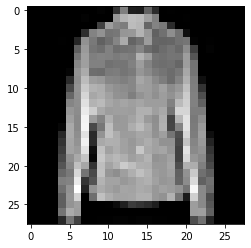

In [4]:
import matplotlib.pyplot as plt
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()

In [5]:
print("Label {}".format(label))

Label 6


## 自定义Sampler

自定义`Sampler`即是自定义数据采样方式。

首先，我们虚构一个`Dataset`类，用于测试。这个类中的`label`标签是混乱的，无法通过控制`index`范围来实现单类别训练。

In [6]:
import torch
import random
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import Sampler

In [7]:
class Data(Dataset):
    def __init__(self):
        self.img = torch.cat([torch.ones(2, 2) for i in range(100)], dim=0)
        self.num_classes = 2
        self.label = torch.tensor([random.randint(0, self.num_classes-1) for i in range(100)])
        
    def __getitem__(self, index):
        return self.img[index], self.label[index]
    
    def __len__(self):
        return len(self.label)

然后，自定义一个`Sampler`类，这个类的作用是生成一个`index`列表，可以理解为重排`data`中的`index`。

In [8]:
class CustomSampler(Sampler):
    def __init__(self, data):
        self.data = data
    
    def __iter__(self):
        indices = []
        for n in range(self.data.num_classes):
            index = torch.where(self.data.label == n)[0]
            indices.append(index)
        indices = torch.cat(indices, dim=0)
        return iter(indices)
    
    def __len__(self):
        return len(self.data)

定义好了之后，可以封装成`DataLoader`并查看运行结果。

In [9]:
d = Data()
s = CustomSampler(d)
dl = DataLoader(d, 8, sampler=s)
for img, label in dl:
    print(label)

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1])


上述结果中，有一个`batch`中还是包含了两种不同类型的标签，为了达到目的，我们还需要定义一个`BatchSampler`类。

## 自定义BatchSampler

In [10]:
class CustomBatchSampler:
    def __init__(self, sampler, batch_size, drop_last):
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last
    
    def __iter__(self):
        batch = []
        i = 0
        sampler_list = list(self.sampler)
        for idx in sampler_list:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
            if(
                i < len(sampler_list) - 1
                and self.sampler.data.label[idx]
                != self.sampler.data.label[sampler_list[i + 1]]
            ):
                if len(batch) > 0 and not self.drop_last:
                    yield batch
                    batch = []
                else:
                    batch = []
            i += 1
        if len(batch) > 0 and not self.drop_last:
            yield batch
    
    def __len__(self):
        if self.drop_last:
            return len(self.sampler)   # self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1)

再次封装成`DataLoader`并查看运行结果：

In [11]:
d = Data()
s = CustomSampler(d)
bs = CustomBatchSampler(s, 8, False)
dl = DataLoader(d, batch_sampler=bs)
for img, label in dl:
    print(label)

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1])


In [12]:
d = Data()
s = CustomSampler(d)
bs = CustomBatchSampler(s, 8, True)
dl = DataLoader(d, batch_sampler=bs)
for img, label in dl:
    print(label)

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


## collate_fn

`collate_fn`是对一个`batch`的样本进行处理。比如如下方法将一个`batch`的样本进行批处理。

In [13]:
def collate_fn(batch):
    data = [item[0] for item in batch]
    target = [torch.reshape(item[1], (-1,)) for item in batch]
    data = torch.stack(data)
    target = torch.stack(target)
    return [data, target]

In [14]:
d = Data()
s = CustomSampler(d)
bs = CustomBatchSampler(s, 8, True)
dl = DataLoader(d, batch_sampler=bs, collate_fn=collate_fn)
for img, label in dl:
    print(label)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
tensor([[1],
        [1],
        [1],
        [1],
   

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data.dataset import Dataset

class HousePriceTrainDataset(Dataset):
    def __init__(self):
        super(HousePriceTrainDataset, self).__init__()
        train_data = pd.read_csv('train.csv')
        test_data = pd.read_csv('test.csv')

        print("The Train Data Shape is : {}".format(train_data.shape))
        print("The Test Daata Shape is : {}\n".format(test_data.shape))

        print("The front four row, [0, 1, 2, 3, -3, -2, -1] columns data: ")
        print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
        print("\n")

        # remove id and concat data
        all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

        numeric_features = all_features.dtypes[all_features.dtypes != "object"].index

        all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
        all_features[numeric_features] = all_features[numeric_features].fillna(0)

        all_features = pd.get_dummies(all_features, dummy_na=True)

        n_train = train_data.shape[0]
        train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
        train_labels = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
    

def get_net(in_features):
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

def log_rmse(net, features, labels, loss):
    clipped_pre = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_pre), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size, loss):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorData(train_features, train_labels)
    train_loader = torch.utils.dataDataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    print(f"num of each batch {len(next(iter(train_loader))[0])} all {len(train_loader)} batch")
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_loader:
            optimizer.zero_grad()
            
            l = loss(net(X), y)
            l.backward()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
    return train_l_sum / k, valid_l_sum / k
            

def main():
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    print("The Train Data Shape is : {}".format(train_data.shape))
    print("The Test Daata Shape is : {}\n".format(test_data.shape))

    print("The front four row, [0, 1, 2, 3, -3, -2, -1] columns data: ")
    print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
    print("\n")

    # remove id and concat data
    all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

    numeric_features = all_features.dtypes[all_features.dtypes != "object"].index

    all_features[numeric_features] = all_features[numeric_features].apply(lambda x : (x - x.mean()) / (x.std()))
    all_features[numeric_features] = all_features[numeric_features].fillna(0)

    all_features = pd.get_dummies(all_features, dummy_na=True)

    n_train = train_data.shape[0]
    train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
    train_labels = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

    loss = nn.MSELoss()
    in_features = train_features.shape[1]
    
    net = get_net(in_features=in_features)
    test_features = None
    test_labels = None
    num_epochs = 10
    learning_rate = 0.001
    weight_decay = 
    train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size, loss)

    print("....")

if __name__ == "__main__":
    main()
    print("done")